# Task 2: Time Series Forecasting Models

## BND Stock Price Prediction

This task involves building a time series forecasting model to predict BND's future stock prices. Below are the step-by-step instructions to develop, evaluate, and refine a forecasting model using common techniques such as **ARIMA**, **SARIMA**, or **LSTM**.

### Step-by-Step Instructions:

#### 1. Choose a Model:
- **ARIMA (AutoRegressive Integrated Moving Average):**  
  Suitable for univariate time series with no seasonality.
- **SARIMA (Seasonal ARIMA):**  
  Extends ARIMA by considering seasonality.
- **LSTM (Long Short-Term Memory):**  
  A type of recurrent neural network (RNN) well-suited for capturing long-term dependencies in time series data.

#### 2. Split the Dataset:
- Divide the dataset into **training** and **testing** sets to evaluate model performance.

#### 3. Train the Model:
- Train the chosen model on the **training set**.

#### 4. Forecast Future Stock Prices:
- Use the model to forecast future stock prices.
- Compare the predictions with the **testing set**.

#### 5. Optimize Model Parameters:
- techniques like **grid search** or **auto_arima** from the `pmdarima` library to find the best `(p, d, q)` parameters.

#### 6. Evaluate Model Performance:
- Calculate evaluation metrics to assess the model's performance:
  - **Mean Absolute Error (MAE)**
  - **Root Mean Squared Error (RMSE)**
  - **Mean Absolute Percentage Error (MAPE)**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Add the parent directory to the system path 
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

In [3]:
from scripts.time_series_forecasting import *
from scripts.forecast_analysis import *

In [4]:
# Load the preprocessed data
df_BND = pd.read_csv('../data/processed/BND_processed.csv')

In [5]:
df_BND.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Daily_Return,MA20,MA50,MA200,Volatility
0,2015-01-02 00:00:00-05:00,63.004189,63.202918,62.996544,63.172344,2218800,0.0,0.0,0.0,0.000062,69.91296,69.92833,70.05721,0.044874
1,2015-01-05 00:00:00-05:00,63.241126,63.378707,63.210552,63.355778,5820100,0.0,0.0,0.0,0.002904,69.91296,69.92833,70.05721,0.044874
2,2015-01-06 00:00:00-05:00,63.462760,63.730276,63.462760,63.539192,3887600,0.0,0.0,0.0,0.002895,69.91296,69.92833,70.05721,0.044874
3,2015-01-07 00:00:00-05:00,63.546834,63.653840,63.478046,63.577408,2433400,0.0,0.0,0.0,0.000601,69.91296,69.92833,70.05721,0.044874
4,2015-01-08 00:00:00-05:00,63.523905,63.523905,63.416898,63.478046,1873400,0.0,0.0,0.0,-0.001563,69.91296,69.92833,70.05721,0.044874


In [6]:
df_BND['Date'] = pd.to_datetime(df_BND['Date'],utc=True).dt.date
df_BND.set_index('Date', inplace=True)

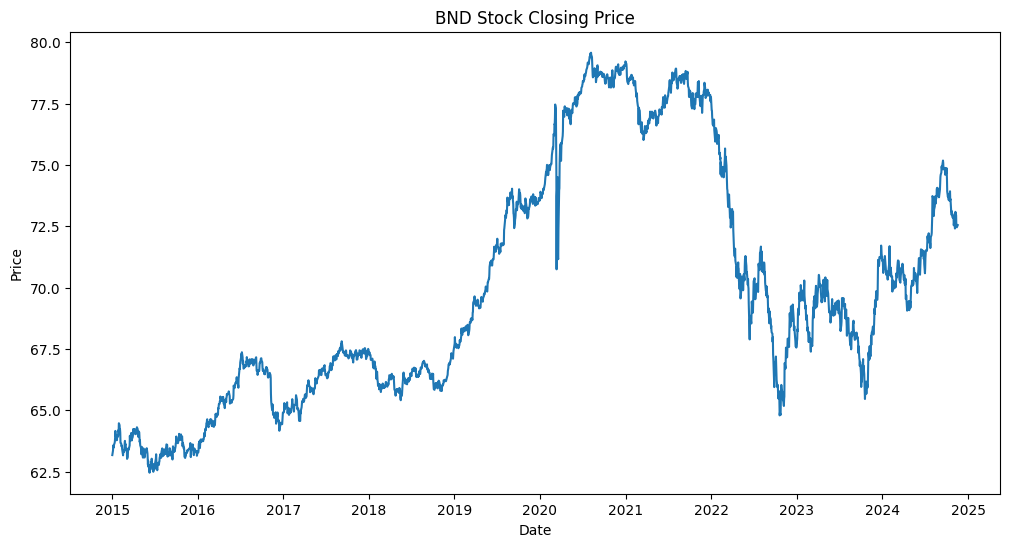

In [7]:
# Stock Closing Price
df_BND['Close'].plot(figsize=(12, 6), title="BND Stock Closing Price", xlabel='Date', ylabel='Price')
plt.show()

seasonal decomposition

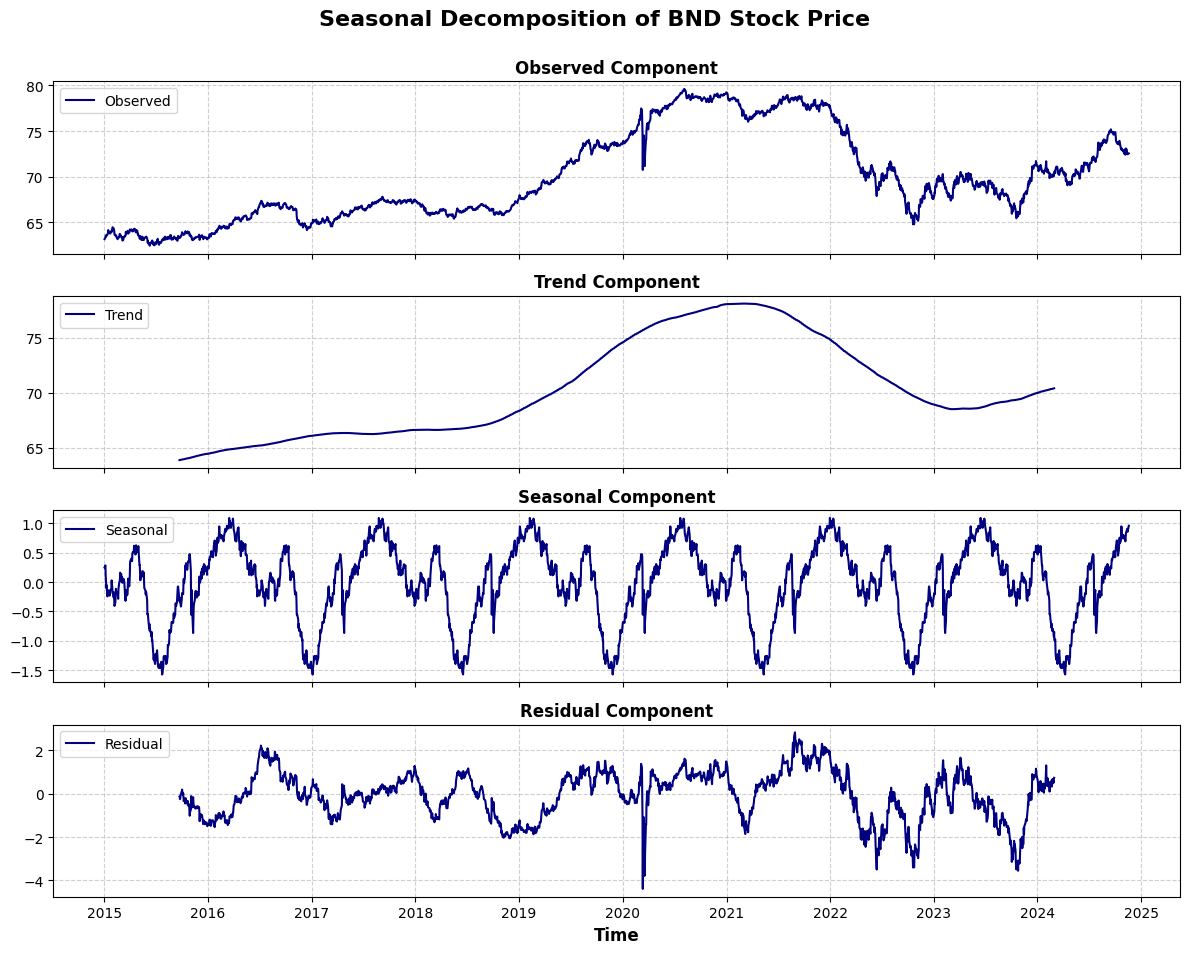

In [8]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(df_BND['Close'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plot each component separately
components = ['Observed', 'Trend', 'Seasonal', 'Residual']
plots = [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid]

for ax, component, data in zip(axes, components, plots):
    ax.plot(data, label=component, color='navy', linewidth=1.5)
    ax.set_title(f"{component} Component", fontsize=12, fontweight='bold')
    ax.grid(visible=True, linestyle='--', alpha=0.6)
    ax.legend(loc="upper left")

plt.xlabel("Time", fontsize=12, fontweight='bold')
fig.suptitle("Seasonal Decomposition of BND Stock Price", fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

ADF test for stationarity 

In [9]:
# Perform ADF test for stationarity 
adf_test(df_BND['Close'], 'BND')

ADF Test for BND:
ADF Statistic: -1.4815373942653007
p-value: 0.5426239561029944



ACF  and PACF for BND Close price

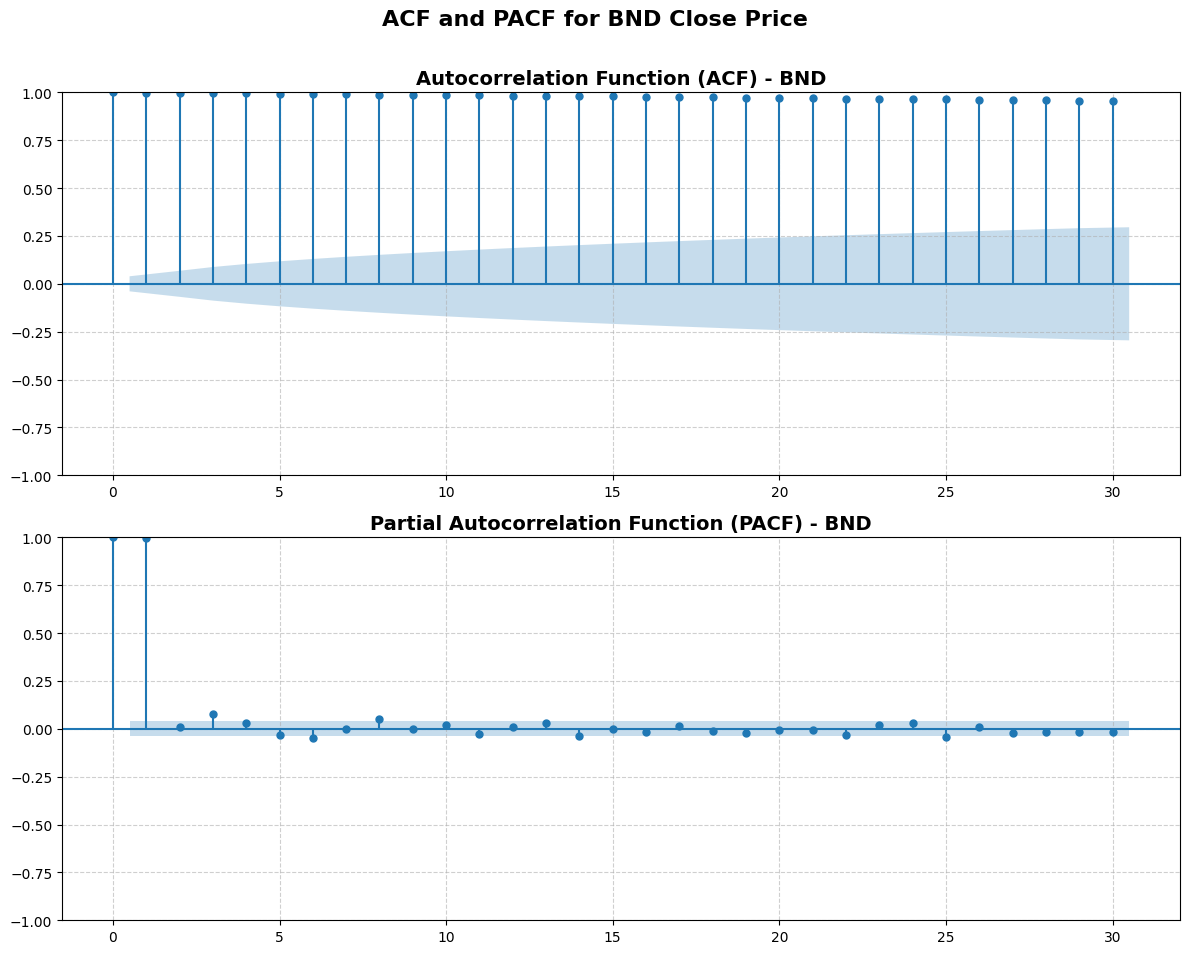

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot ACF for BND Close price
plot_acf(df_BND['Close'], ax=ax[0], lags=30)
ax[0].set_title("Autocorrelation Function (ACF) - BND", fontsize=14, fontweight='bold')
ax[0].grid(visible=True, linestyle='--', alpha=0.6)

# Plot PACF for BND Close price
plot_pacf(df_BND['Close'], ax=ax[1], lags=30, method='ywm')
ax[1].set_title("Partial Autocorrelation Function (PACF) - BND", fontsize=14, fontweight='bold')
ax[1].grid(visible=True, linestyle='--', alpha=0.6)

# Add a main title for the figure
fig.suptitle("ACF and PACF for BND Close Price", fontsize=16, fontweight='bold', y=0.95)

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


In [11]:
# Check for missing values and fill them for BND data
print("Missing values in BND:")
print(df_BND.isnull().sum())

# Fill missing values (if any)
df_BND.fillna(method='ffill', inplace=True)
df_BND.fillna(method='bfill', inplace=True)  # Optionally fill backward if leading NaNs exist

# Extract 'Close' prices for BND after filling missing values
bnd_close = df_BND['Close']

#  Scale or normalize BND ' Close' prices
# Example: min-max scaling
bnd_close_scaled = (bnd_close - bnd_close.min()) / (bnd_close.max() - bnd_close.min())

print("BND data preparation complete.")


Missing values in BND:
Open             0
High             0
Low              0
Close            0
Volume           0
Dividends        0
Stock Splits     0
Capital Gains    0
Daily_Return     0
MA20             0
MA50             0
MA200            0
Volatility       0
dtype: int64
BND data preparation complete.


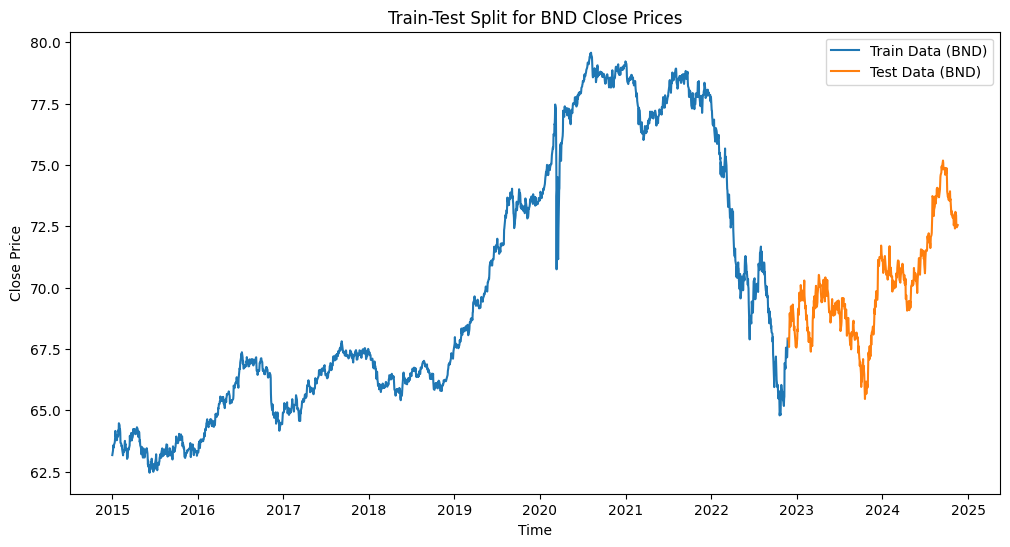

In [12]:
# Define the split ratio
split_ratio = 0.8
train_size = int(len(bnd_close) * split_ratio)

# Split the data for BND
bnd_train, bnd_test = bnd_close[:train_size], bnd_close[train_size:]

# Plot Train-Test Split for BND
plt.figure(figsize=(12, 6))
plt.plot(bnd_train, label='Train Data (BND)')
plt.plot(bnd_test, label='Test Data (BND)')
plt.legend()
plt.title("Train-Test Split for BND Close Prices")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()


### ARIMA MODEL 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-229.483, Time=4.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-186.813, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-184.930, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-184.962, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-188.600, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-203.552, Time=2.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-206.625, Time=1.45 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-227.866, Time=3.35 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-192.332, Time=4.68 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-188.038, Time=1.72 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-206.545, Time=2.90 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-207.836, Time=0.59 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-222.330, Time=1.72 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-231.246, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0]          

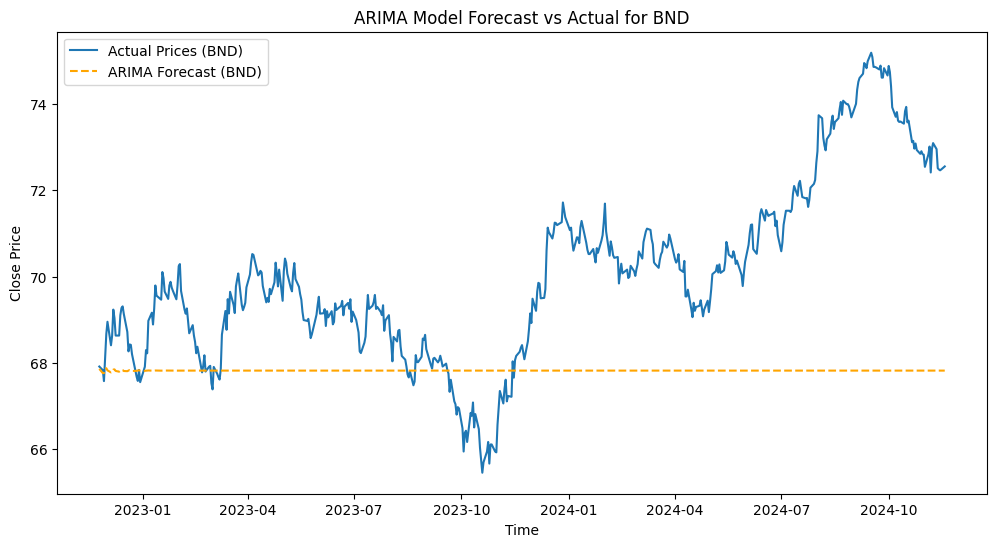

In [13]:
# Apply ARIMA for BND
arima_forecast, bnd_test, model_arima_fit = apply_arima(bnd_train, bnd_test)

# Plot actual vs ARIMA forecast for BND
plt.figure(figsize=(12, 6))
plt.plot(bnd_test.index, bnd_test.values, label='Actual Prices (BND)')
plt.plot(bnd_test.index, arima_forecast, label='ARIMA Forecast (BND)', linestyle='--', color='orange')

# Add title and legend
plt.title("ARIMA Model Forecast vs Actual for BND")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

Residual Analysis Plot
    residuals (difference between actual and forecasted values) to check for pattern.

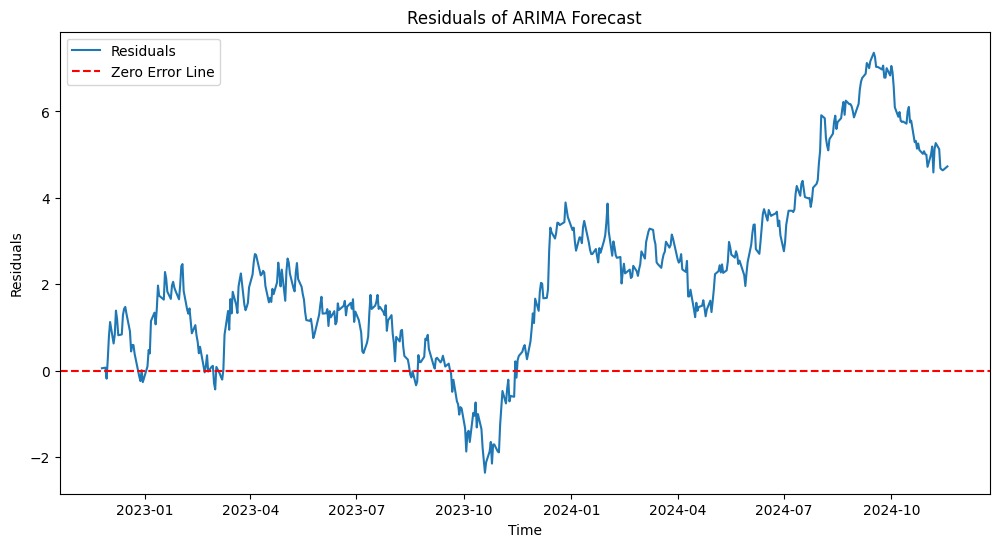

In [14]:
residuals = bnd_test.values - arima_forecast
plt.figure(figsize=(12, 6))
plt.plot(bnd_test.index, residuals, label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Error Line')
plt.title("Residuals of ARIMA Forecast")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.show()


ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) Plots to understand whether residuals are white noise and whether any autocorrelation remains.

<Figure size 1200x600 with 0 Axes>

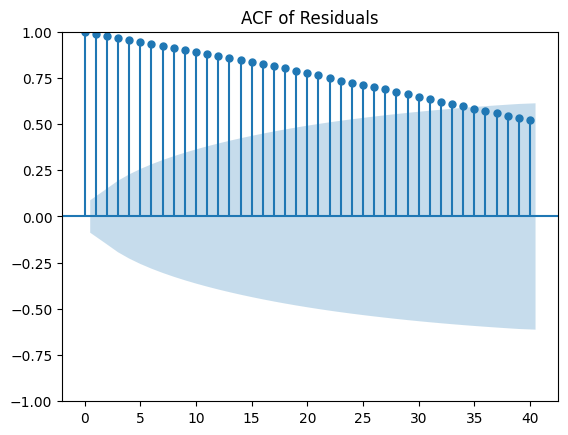

<Figure size 1200x600 with 0 Axes>

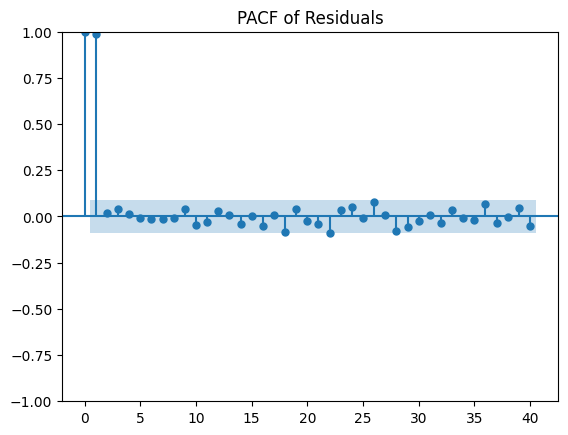

In [15]:
# ACF and PACF of residuals
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=40, title='ACF of Residuals')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(residuals, lags=40, title='PACF of Residuals')
plt.show()

In-sample Fit

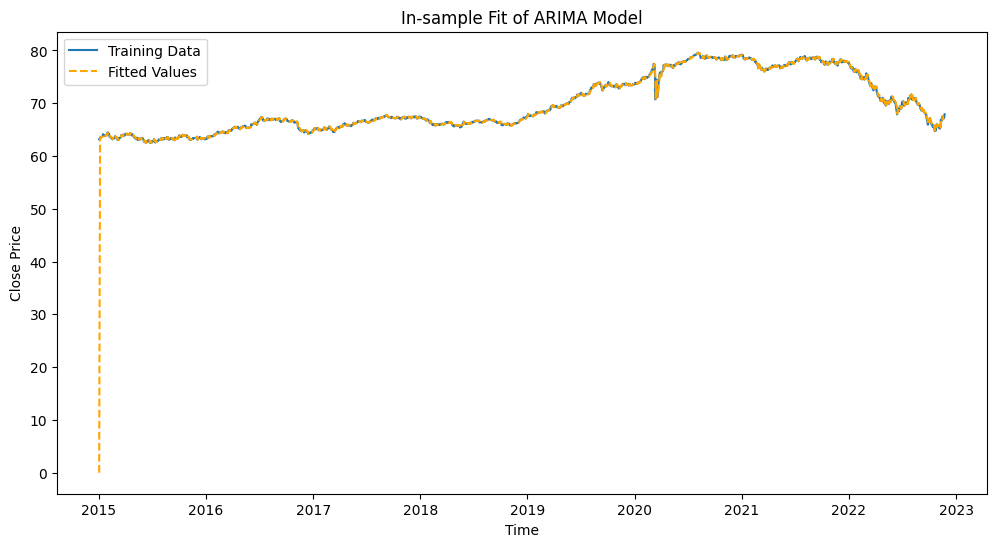

In [16]:
fitted_values = model_arima_fit.fittedvalues
plt.figure(figsize=(12, 6))
plt.plot(bnd_train.index, bnd_train.values, label='Training Data')
plt.plot(bnd_train.index, fitted_values, label='Fitted Values', linestyle='--', color='orange')
plt.title("In-sample Fit of ARIMA Model")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

Forecast with Prediction Intervals 

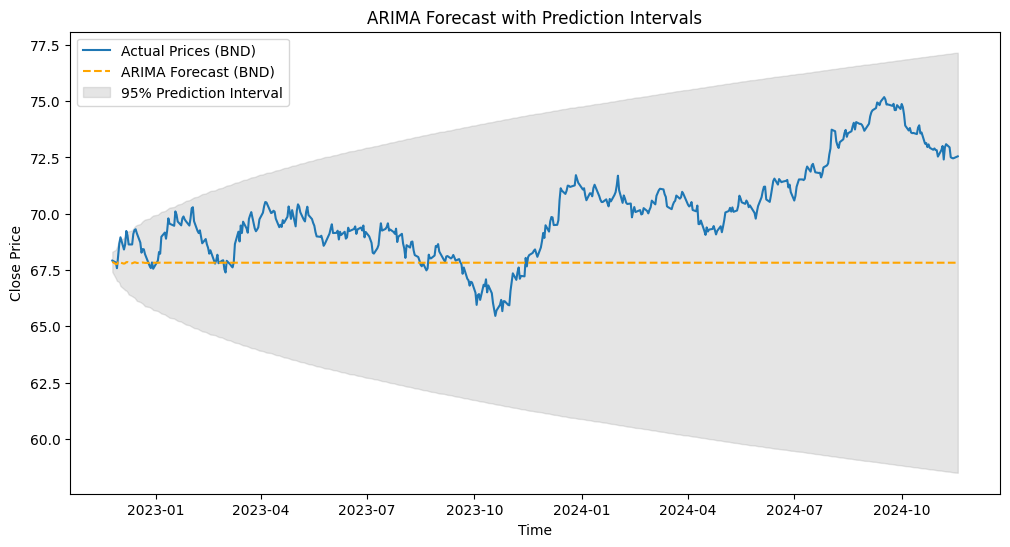

In [17]:
# Get forecast with confidence intervals
forecast_object = model_arima_fit.get_forecast(steps=len(bnd_test))
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int(alpha=0.05)  # 95% prediction interval

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(bnd_test.index, bnd_test.values, label='Actual Prices (BND)')
plt.plot(bnd_test.index, forecast, label='ARIMA Forecast (BND)', linestyle='--', color='orange')
plt.fill_between(bnd_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Prediction Interval')
plt.title("ARIMA Forecast with Prediction Intervals")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

Distribution of Residuals 

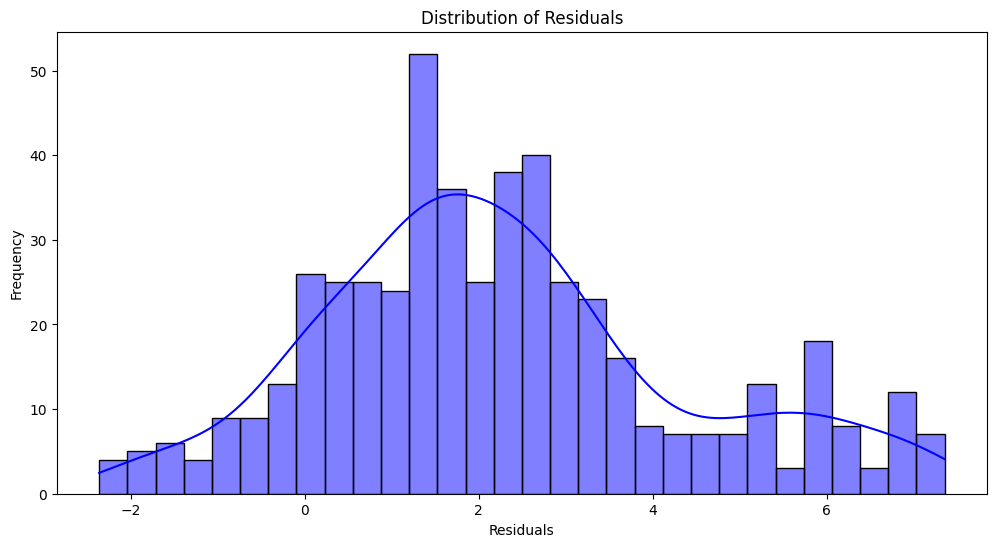

In [18]:
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

ARIMA model’s diagnostic plots to check for heteroscedasticity, normality, and autocorrelation.

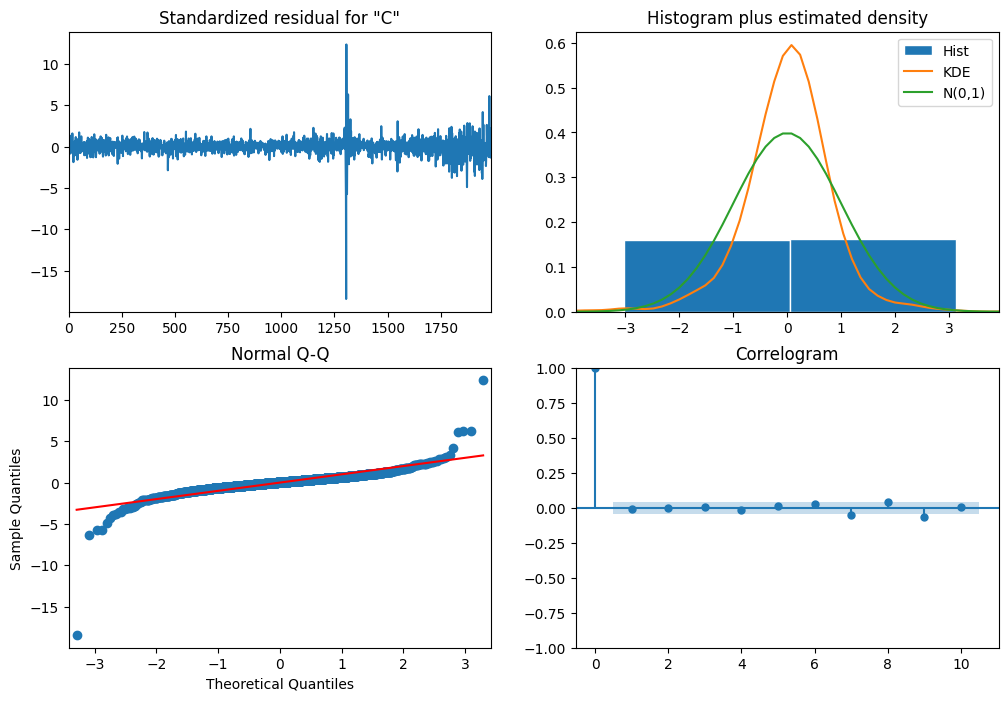

In [19]:
model_arima_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

Rolling Mean and Standard Deviation

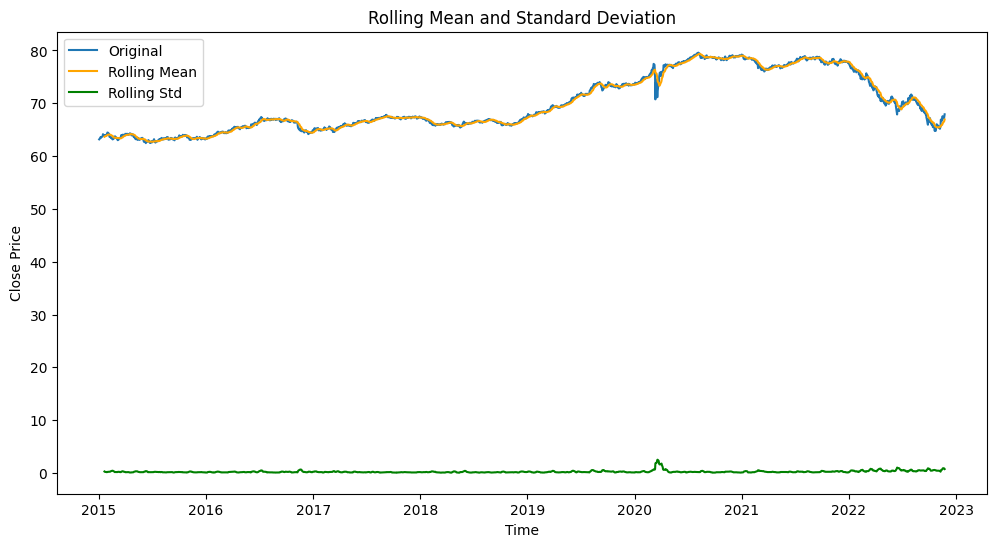

In [20]:
rolling_mean = bnd_train.rolling(window=12).mean()
rolling_std = bnd_train.rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(bnd_train, label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='orange')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.title("Rolling Mean and Standard Deviation")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

### SARIMA MODEL 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-186.813, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-194.788, Time=0.77 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-193.718, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-188.600, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-184.930, Time=0.14 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-196.972, Time=0.80 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-193.667, Time=0.49 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-198.746, Time=0.57 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-195.475, Time=0.25 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-196.585, Time=0.29 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-197.032, Time=0.91 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-199.181, Time=1.67 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=-196.061, Time=1.04 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-197.116, Time=1.18 sec
 ARIMA(1,1,1)(0,0,0

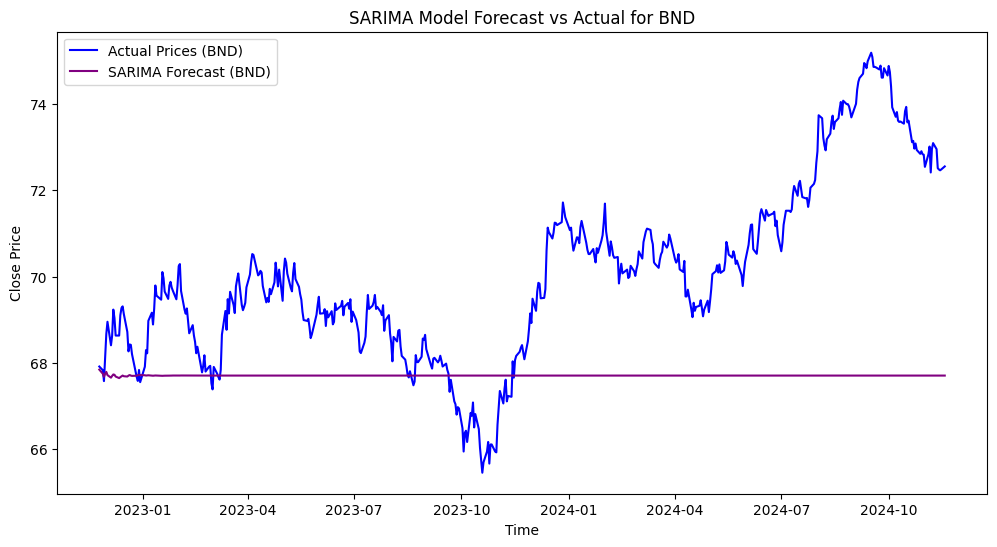

In [21]:
# SARIMA modeling for BND
# Automatically find the optimal SARIMA parameters with restricted search space
sarima_model_bnd = pm.auto_arima(
    bnd_train,
    seasonal=True,
    m=12,
    start_p=0, max_p=2,    # Restrict p parameters
    start_q=0, max_q=2,    # Restrict q parameters
    start_P=0, max_P=1,    # Restrict seasonal P parameters
    start_Q=0, max_Q=1,    # Restrict seasonal Q parameters
    max_d=1,               # Restrict differencing
    max_D=1,               # Restrict seasonal differencing
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,         # Use stepwise search instead of grid search
    n_fits=10             # Limit number of models to evaluate
)

print(f"Optimal SARIMA parameters for BND: {sarima_model_bnd.order}x{sarima_model_bnd.seasonal_order}")

# Fit the SARIMA model with optimized settings
model_sarima_bnd = SARIMAX(
    bnd_train,
    order=sarima_model_bnd.order,
    seasonal_order=sarima_model_bnd.seasonal_order,
    enforce_stationarity=False,    # Speed up fitting
    enforce_invertibility=False    # Speed up fitting
)

# Fit with optimized solver settings
model_sarima_fit_bnd = model_sarima_bnd.fit(
    disp=False,
    method='lbfgs',    # Faster optimization algorithm
    maxiter=50         # Limit maximum iterations
)

# Forecast for the test period
sarima_forecast_bnd = model_sarima_fit_bnd.forecast(steps=len(bnd_test))

# Plot actual vs SARIMA forecast for BND
plt.figure(figsize=(12, 6))
plt.plot(bnd_test, label='Actual Prices (BND)', color='blue')
plt.plot(bnd_test.index, sarima_forecast_bnd, label='SARIMA Forecast (BND)', color='purple')
plt.legend()
plt.title("SARIMA Model Forecast vs Actual for BND")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

 Residuals

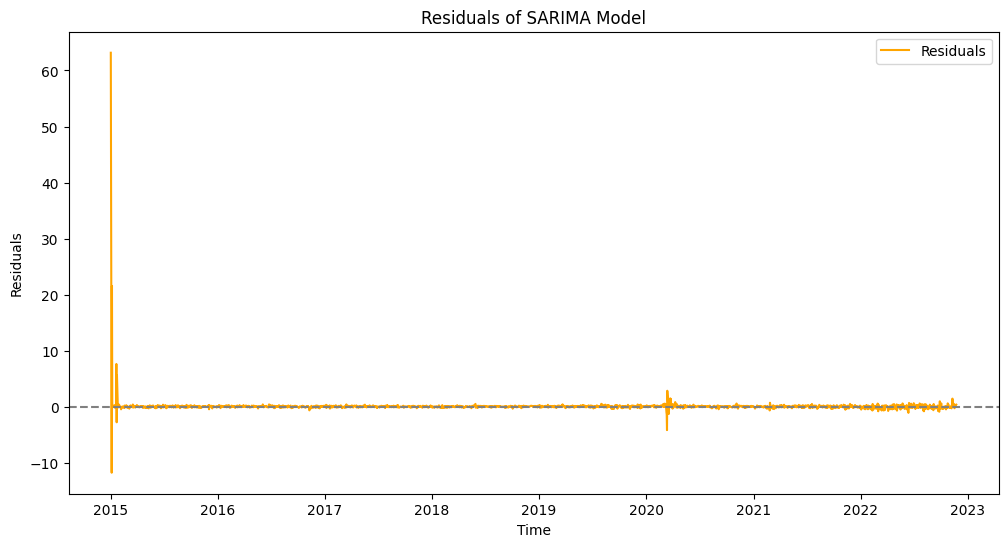

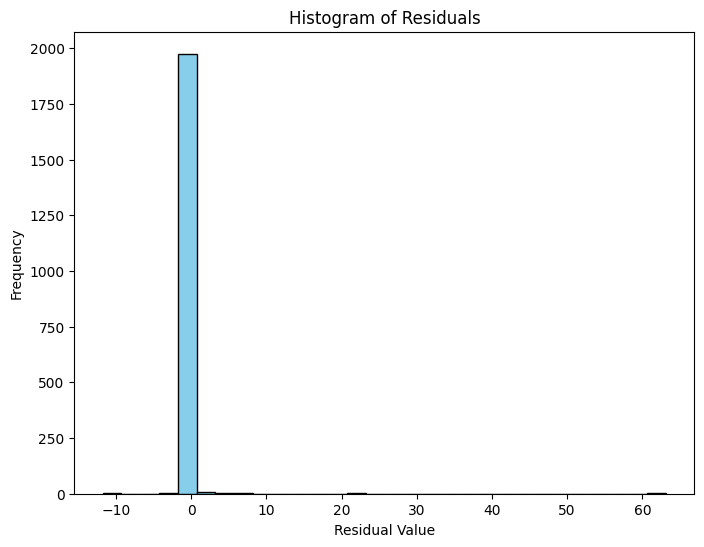

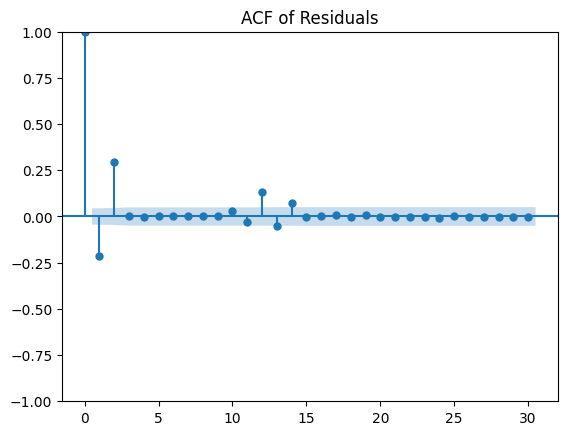

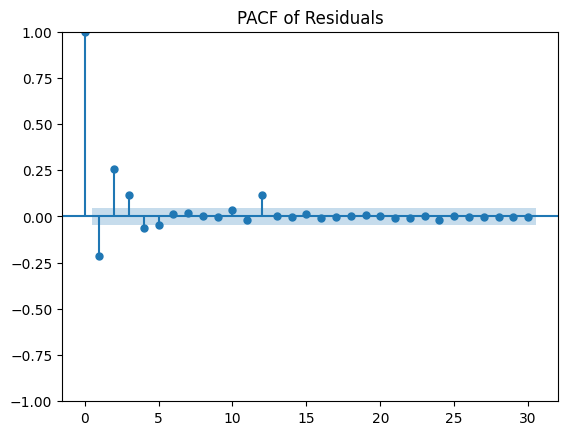

In [22]:
# Residuals
residuals = model_sarima_fit_bnd.resid

# Plot residuals time series
plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals", color="orange")
plt.axhline(0, linestyle="--", color="gray")
plt.title("Residuals of SARIMA Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color="skyblue", edgecolor="black")
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()


# ACF and PACF of residuals
plot_acf(residuals, lags=30)
plt.title("ACF of Residuals")
plt.show()

plot_pacf(residuals, lags=30)
plt.title("PACF of Residuals")
plt.show()


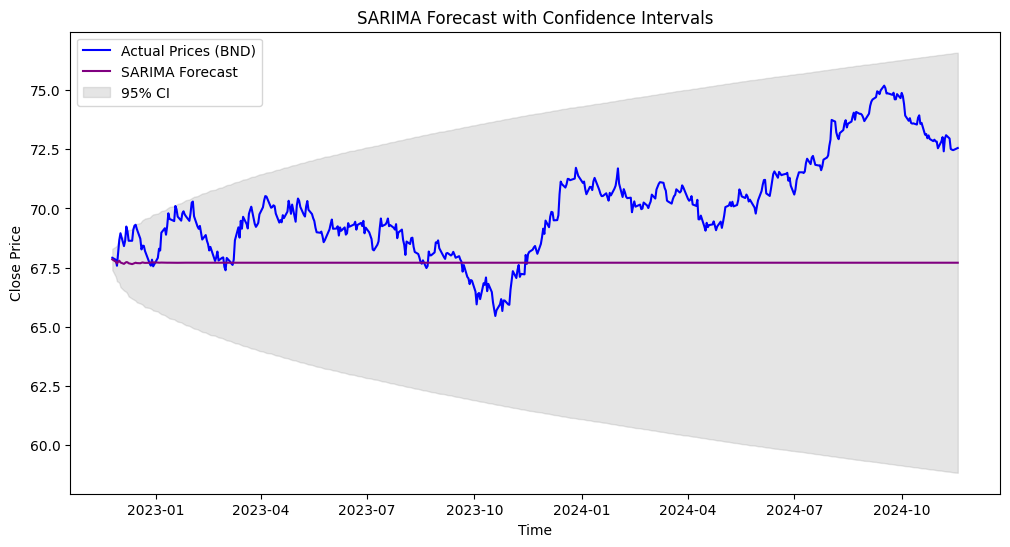

In [23]:
# Get forecast with confidence intervals
forecast_object = model_sarima_fit_bnd.get_forecast(steps=len(bnd_test))
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

# Plot forecast with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(bnd_test, label="Actual Prices (BND)", color="blue")
plt.plot(bnd_test.index, forecast, label="SARIMA Forecast", color="purple")
plt.fill_between(bnd_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color="gray", alpha=0.2, label="95% CI")
plt.legend()
plt.title("SARIMA Forecast with Confidence Intervals")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.show()

Sarima Model Diagnostics 

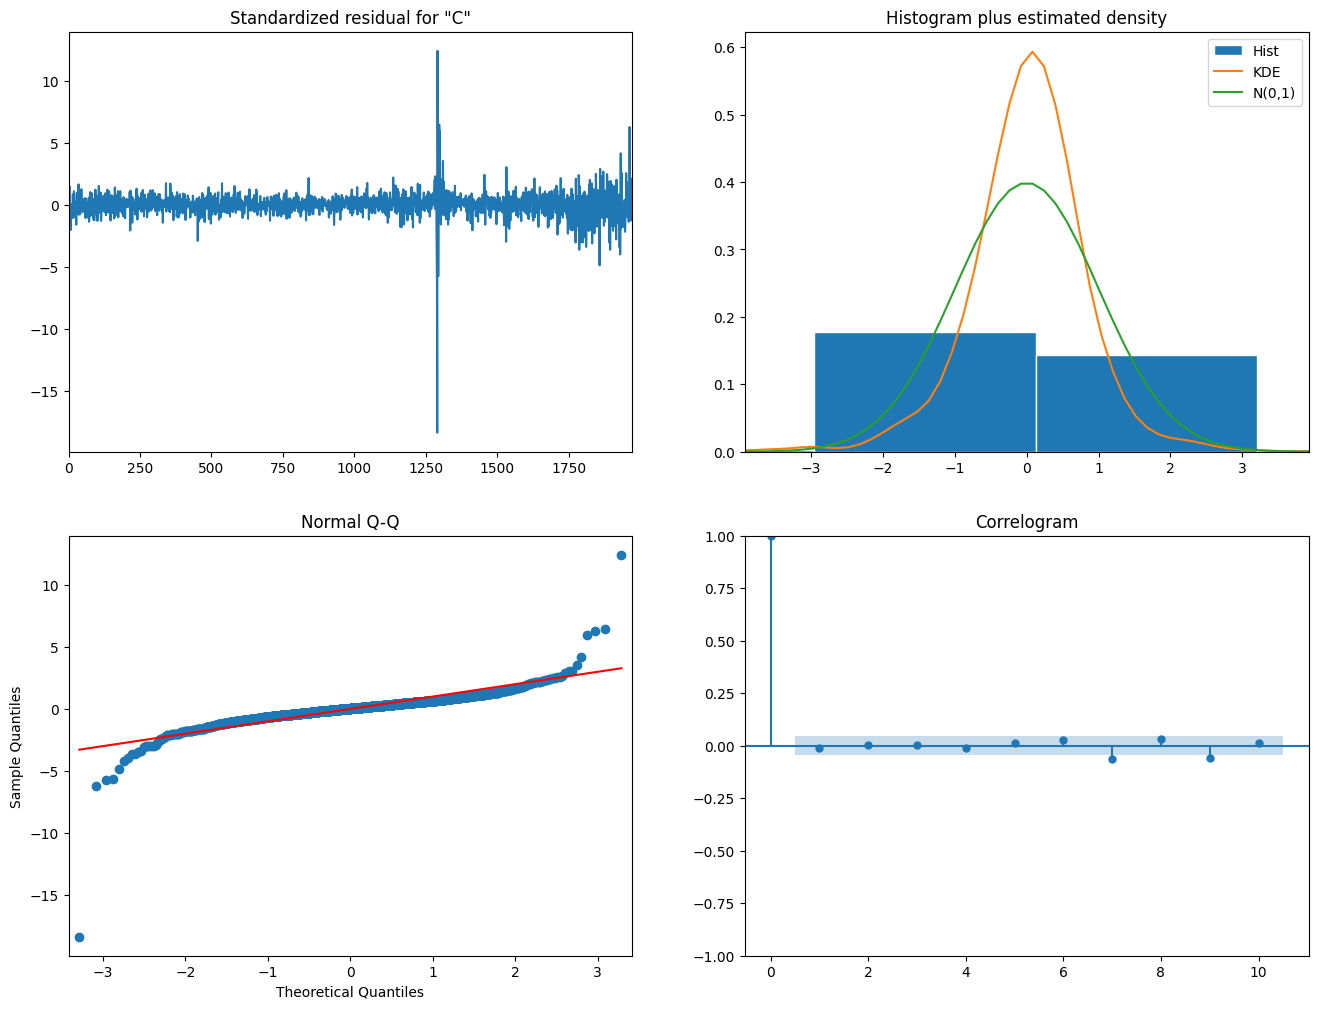

In [24]:
# Model diagnostics
model_sarima_fit_bnd.plot_diagnostics(figsize=(16, 12))
plt.show()

In [25]:
mae = mean_absolute_error(bnd_test, sarima_forecast_bnd)
rmse = np.sqrt(mean_squared_error(bnd_test, sarima_forecast_bnd))
mape = np.mean(np.abs((bnd_test - sarima_forecast_bnd) / bnd_test)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 2.5255029513034892
Root Mean Squared Error (RMSE): 3.128520588404545
Mean Absolute Percentage Error (MAPE): nan%


In [26]:
# Generate forecast and confidence intervals
forecast_object = model_sarima_fit_bnd.get_forecast(steps=len(bnd_test))
conf_intervals = forecast_object.conf_int()

# Rename columns for clarity
conf_intervals.columns = ['Lower Close', 'Upper Close']

# Display the confidence intervals as a table
print(conf_intervals)


      Lower Close  Upper Close
1989    67.401003    68.294082
1990    67.115218    68.387537
1991    66.924357    68.437503
1992    66.903026    68.603754
1993    66.849254    68.738916
...           ...          ...
2482    58.881326    76.535861
2483    58.872418    76.544770
2484    58.863519    76.553669
2485    58.854628    76.562559
2486    58.845747    76.571441

[498 rows x 2 columns]


### LSTM MODEL 

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.1824e-04
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.5441e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.9356e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.6429e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4613e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.5160e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.9407e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.2893e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.2732e-04
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.4271e-04
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.3701e-04
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.6127e-04
Epoch 13/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.8679e-04
Epoch 14/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.4481e-04
Epoch 15/50
61/

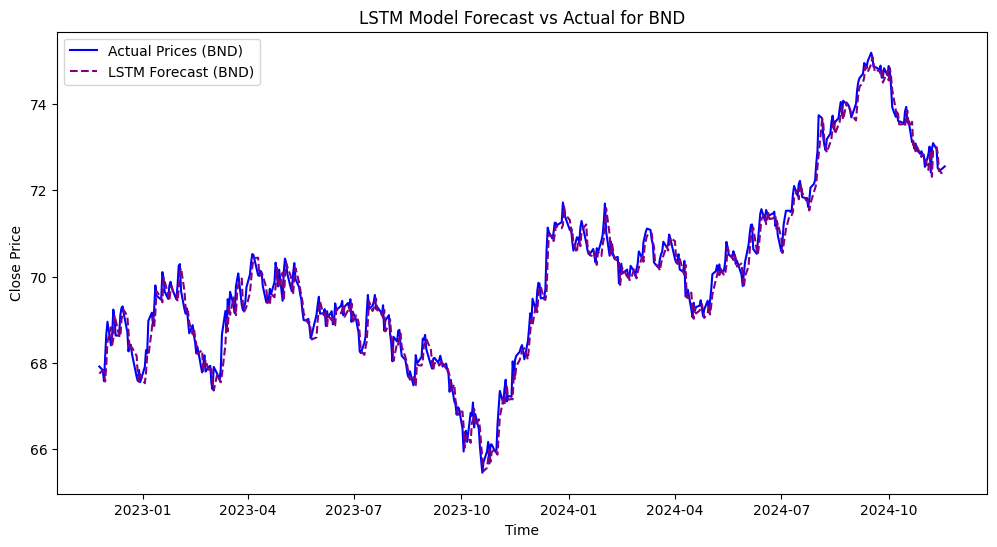

In [27]:
# Apply LSTM to BND data
scaler, X_train, y_train, X_test, bnd_test = prepare_lstm_data(bnd_train, bnd_test)

# Build, train, and predict with the LSTM model
model_lstm = build_lstm_model(X_train)
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
lstm_forecast = train_and_predict_lstm(model_lstm, X_train, y_train, X_test)

# Inverse transform predictions to original scale
lstm_forecast = scaler.inverse_transform(lstm_forecast)

# Plot actual vs LSTM forecast for BND
plt.figure(figsize=(12, 6))
plt.plot(bnd_test.index, bnd_test.values, label='Actual Prices (BND)', color='blue')
plt.plot(bnd_test.index, lstm_forecast, label='LSTM Forecast (BND)', linestyle='--', color='purple')
plt.title("LSTM Model Forecast vs Actual for BND")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()

LSTM Training Loss 

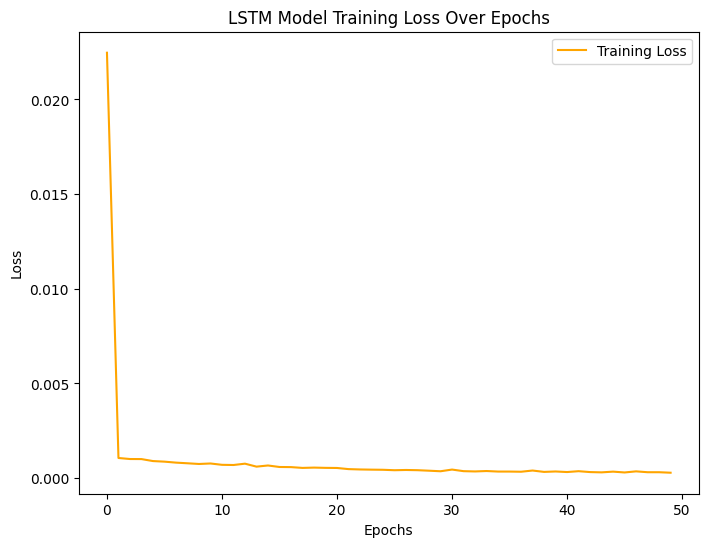

In [28]:
# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.title("LSTM Model Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

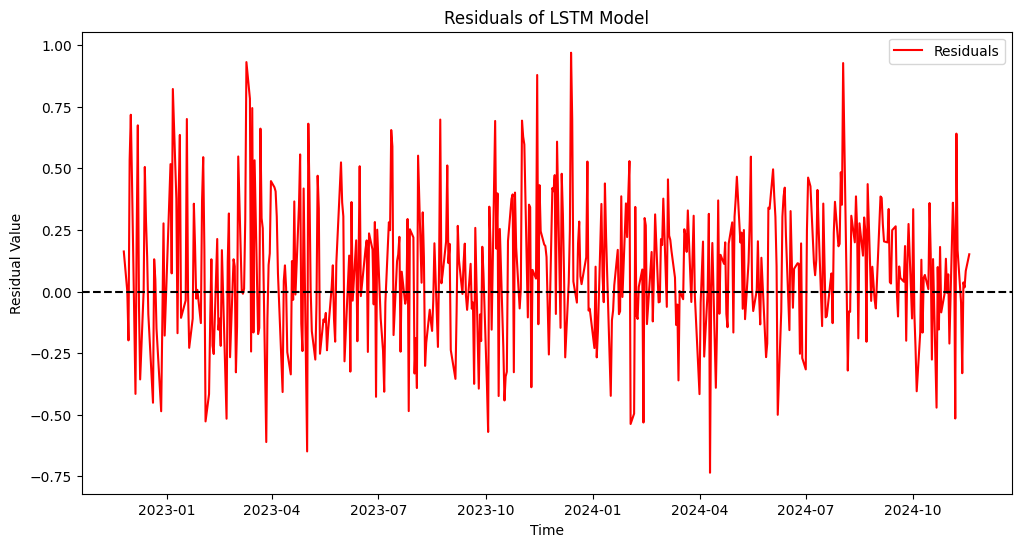

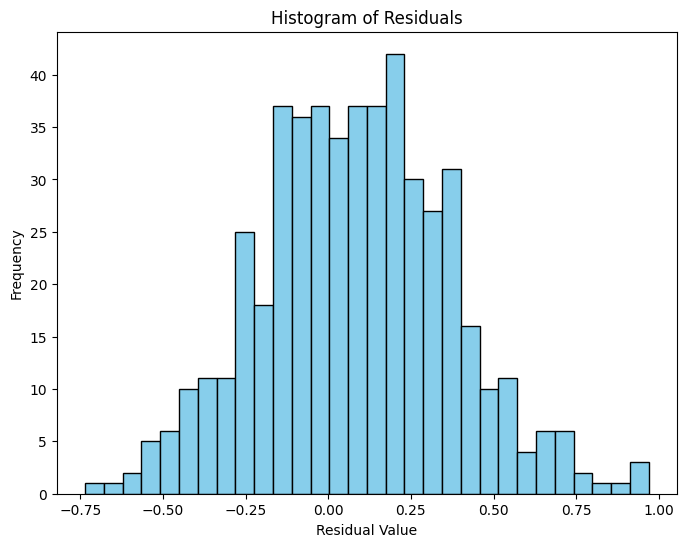

In [29]:
# Residuals
residuals = bnd_test.values - lstm_forecast.flatten()

# Plot residuals time series
plt.figure(figsize=(12, 6))
plt.plot(bnd_test.index, residuals, label="Residuals", color="red")
plt.axhline(0, linestyle="--", color="black")
plt.title("Residuals of LSTM Model")
plt.xlabel("Time")
plt.ylabel("Residual Value")
plt.legend()
plt.show()

# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color="skyblue", edgecolor="black")
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()


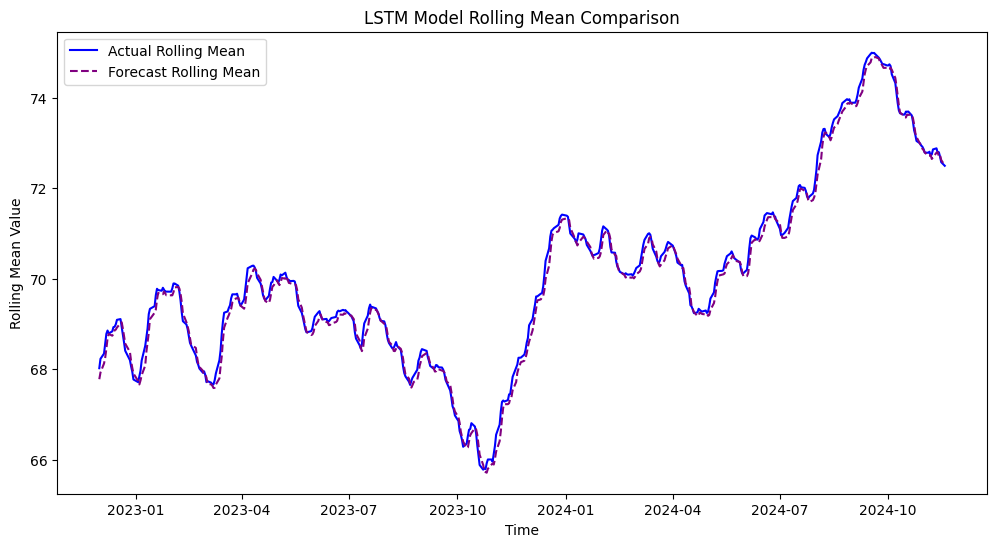

In [30]:
# Rolling means
actual_rolling = bnd_test.rolling(window=5).mean()
forecast_rolling = pd.Series(lstm_forecast.flatten(), index=bnd_test.index).rolling(window=5).mean()

plt.figure(figsize=(12, 6))
plt.plot(bnd_test.index, actual_rolling, label="Actual Rolling Mean", color="blue")
plt.plot(bnd_test.index, forecast_rolling, label="Forecast Rolling Mean", linestyle="--", color="purple")
plt.title("LSTM Model Rolling Mean Comparison")
plt.xlabel("Time")
plt.ylabel("Rolling Mean Value")
plt.legend()
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


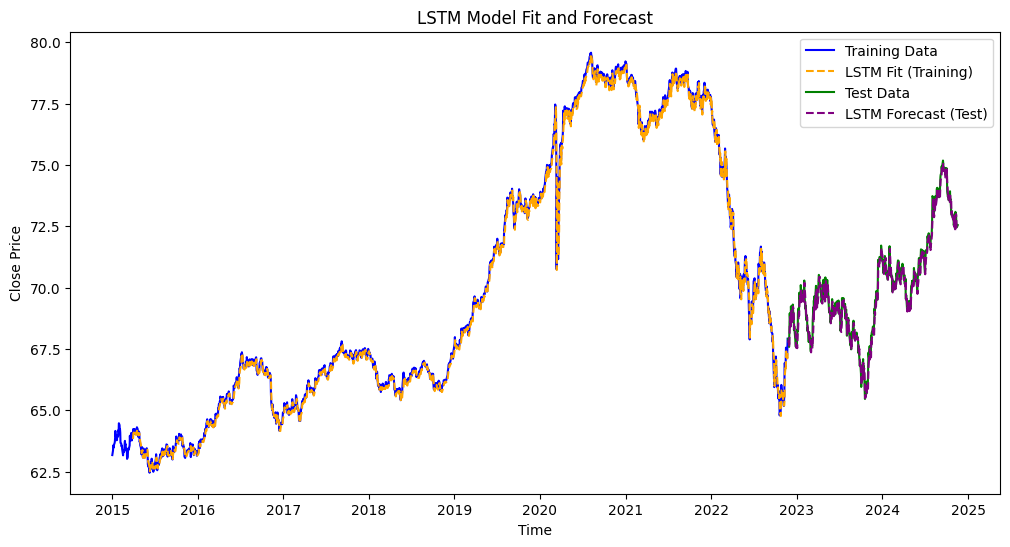

In [31]:
# Get training predictions
train_predictions = model_lstm.predict(X_train)
train_predictions = scaler.inverse_transform(train_predictions)

plt.figure(figsize=(12, 6))
plt.plot(bnd_train.index, bnd_train.values, label="Training Data", color="blue")
plt.plot(bnd_train.index[60:], train_predictions.flatten(), label="LSTM Fit (Training)", linestyle="--", color="orange")
plt.plot(bnd_test.index, bnd_test.values, label="Test Data", color="green")
plt.plot(bnd_test.index, lstm_forecast.flatten(), label="LSTM Forecast (Test)", linestyle="--", color="purple")
plt.title("LSTM Model Fit and Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()


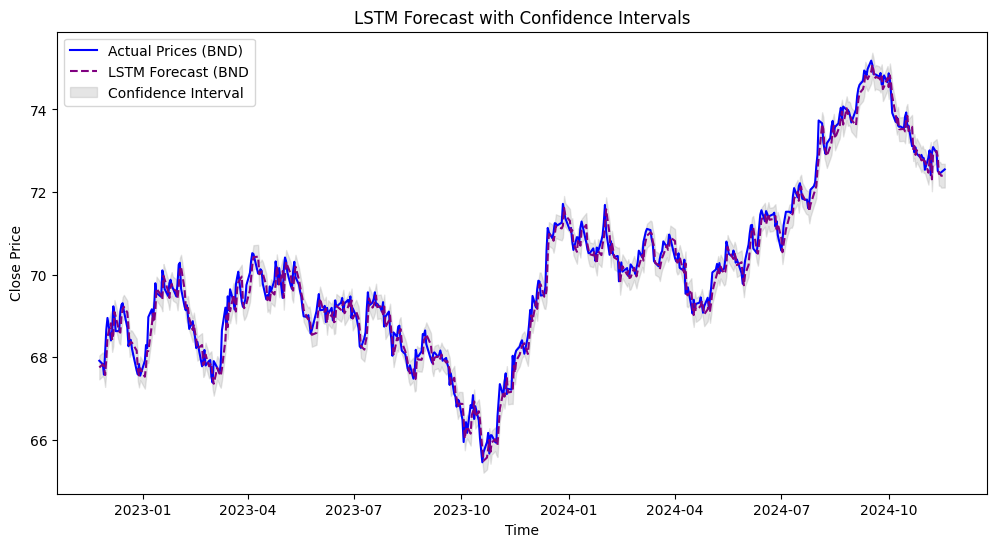

In [32]:
# Compute confidence intervals (e.g., ± standard deviation of residuals)
forecast_std = np.std(residuals)
lower_bound = lstm_forecast.flatten() - forecast_std
upper_bound = lstm_forecast.flatten() + forecast_std

plt.figure(figsize=(12, 6))
plt.plot(bnd_test.index, bnd_test.values, label="Actual Prices (BND)", color="blue")
plt.plot(bnd_test.index, lstm_forecast.flatten(), label="LSTM Forecast (BND", linestyle="--", color="purple")
plt.fill_between(bnd_test.index, lower_bound, upper_bound, color="gray", alpha=0.2, label="Confidence Interval")
plt.title("LSTM Forecast with Confidence Intervals")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In [33]:

mae = mean_absolute_error(bnd_test, lstm_forecast)
rmse = np.sqrt(mean_squared_error(bnd_test, lstm_forecast))
mape = np.mean(np.abs((bnd_test.values - lstm_forecast.flatten()) / bnd_test.values)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 0.2390557254653379
Root Mean Squared Error (RMSE): 0.299753960687593
Mean Absolute Percentage Error (MAPE): 0.34%


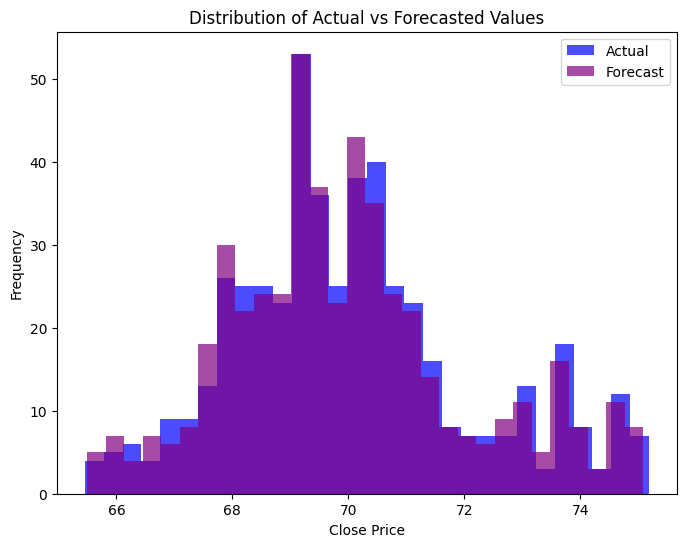

In [34]:
plt.figure(figsize=(8, 6))
plt.hist(bnd_test.values, bins=30, alpha=0.7, label="Actual", color="blue")
plt.hist(lstm_forecast.flatten(), bins=30, alpha=0.7, label="Forecast", color="purple")
plt.title("Distribution of Actual vs Forecasted Values")
plt.xlabel("Close Price")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### Model Comparision 

In [35]:
# Evaluate models
arima_mae, arima_rmse, arima_mape = calculate_metrics(bnd_test, arima_forecast)
sarima_mae, sarima_rmse, sarima_mape = calculate_metrics(bnd_test, sarima_forecast_bnd)
lstm_mae, lstm_rmse, lstm_mape = calculate_metrics(bnd_test, lstm_forecast)

# Create a DataFrame for the metrics
metrics_data = {
    "Model": ["ARIMA", "SARIMA", "LSTM"],
    "MAE": [arima_mae, sarima_mae, lstm_mae],
    "RMSE": [arima_rmse, sarima_rmse, lstm_rmse],
    "MAPE": [arima_mape, sarima_mape, lstm_mape],
}

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)

    Model       MAE      RMSE      MAPE
0   ARIMA  2.434953  3.042855  0.034081
1  SARIMA  2.525503  3.128521  0.035358
2    LSTM  0.239056  0.299754  0.003424


## Task 3: Forecast Future Market Trends
In this task, we use the model developed in Task 2 to forecast BND's future stock prices. The goal is to generate future price predictions, analyze the results, and provide insights on potential trends and risks.

### Use the Trained Model for Forecasting
- used the model(SARIMA and LSTM) to generate forecasts for 6-12 months.

### Forecast Analysis
- Visualized the forecast alongside historical data.
- confidence intervals to show the range within which future prices are expected to lie.

### Interpret the Results: Trend Analysis
1. Look for long-term trends (upward, downward, or stable).
2. Identify any patterns or anomalies in the forecast.

### Interpret the Results: Volatility and Risk
- Discuss the level of uncertainty captured by the confidence intervals.
- Highlight any periods where volatility is expected to increase.

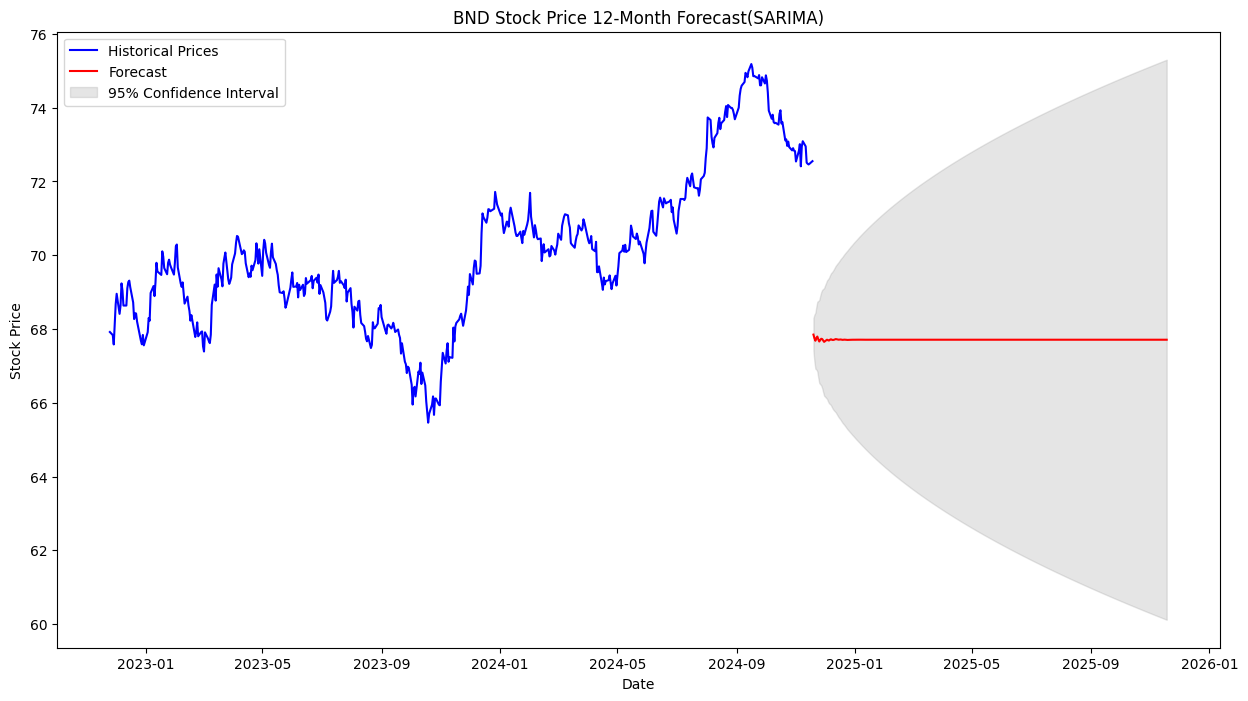


--- BND Stock Price Forecast Analysis ---

Trend Analysis:
Trend Direction: downward
Price Change: -0.20%

Volatility and Risk:
Overall Volatility: 0.01
Confidence Interval Width: 10.17

Market Opportunities:

Market Risks:


In [36]:
# Generate 12-month forecast with confidence intervals
forecast_steps = 365  # 12 months of trading days
forecast_object = model_sarima_fit_bnd.get_forecast(steps=forecast_steps)
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

# Plotting forecast
plt.figure(figsize=(15, 8))
plt.plot(bnd_test.index, bnd_test.values, label='Historical Prices', color='blue')
plt.plot(pd.date_range(start=bnd_test.index[-1], periods=forecast_steps+1)[1:], forecast, label='Forecast', color='red')
plt.fill_between(
    pd.date_range(start=bnd_test.index[-1], periods=forecast_steps+1)[1:], 
    conf_int.iloc[:, 0], 
    conf_int.iloc[:, 1], 
    color='gray', alpha=0.2, 
    label='95% Confidence Interval'
)
plt.title('BND Stock Price 12-Month Forecast(SARIMA)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



trend_direction, price_change = analyze_trend(forecast)

volatility_analysis = analyze_volatility(forecast, conf_int)

opportunities, risks = identify_market_opportunities(forecast, conf_int)

# Comprehensive Report
print("\n--- BND Stock Price Forecast Analysis ---")
print(f"\nTrend Analysis:")
print(f"Trend Direction: {trend_direction}")
print(f"Price Change: {price_change:.2f}%")

print("\nVolatility and Risk:")
print(f"Overall Volatility: {volatility_analysis['overall_volatility']:.2f}")
print(f"Confidence Interval Width: {volatility_analysis['confidence_interval_width']:.2f}")

print("\nMarket Opportunities:")
for opp in opportunities:
    print(f"Potential Price Increase: {opp['potential_increase']:.2f} from {opp['start_date']} to {opp['end_date']}")

print("\nMarket Risks:")
for risk in risks:
    print(f"Potential Price Decline: {risk['potential_decline']:.2f} from {risk['start_date']} to {risk['end_date']}")

In [37]:
# Confidence Interval Statistics
ci_stats = {
    'Mean Lower Bound': conf_int.iloc[:, 0].mean(),
    'Mean Upper Bound': conf_int.iloc[:, 1].mean(),
    'Lower Bound Volatility': conf_int.iloc[:, 0].std(),
    'Upper Bound Volatility': conf_int.iloc[:, 1].std()
}
print("\nConfidence Interval Statistics:")
for key, value in ci_stats.items():
    print(f"{key}: {value:.2f}")


Confidence Interval Statistics:
Mean Lower Bound: 62.62
Mean Upper Bound: 72.79
Lower Bound Volatility: 1.77
Upper Bound Volatility: 1.77


### LSTM FORECASTING 

In [38]:
# Prepare the full dataset for LSTM forecasting
full_data = pd.concat([bnd_train, bnd_test])
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(full_data.values.reshape(-1, 1))
X_forecast = create_forecast_sequences(scaled_data)
last_sequence = scaled_data[-60:]

# Generate 12-month forecast
forecast_steps = 365  # 12 months of trading days

# Use the trained LSTM model to forecast
forecast_scaled = []
current_sequence = last_sequence

for _ in range(forecast_steps):
    next_pred = model_lstm.predict(current_sequence.reshape(1, 60, 1))
    forecast_scaled.append(next_pred[0, 0])
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[-1] = next_pred[0, 0]

# Inverse transform the forecast
forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Create forecast index
forecast_index = pd.date_range(start=bnd_test.index[-1], periods=forecast_steps+1)[1:]

# Compute forecast confidence intervals using residuals
residuals = bnd_test.values - lstm_forecast.flatten()
forecast_std = np.std(residuals)
lower_bound = forecast - forecast_std
upper_bound = forecast + forecast_std


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [39]:
# Market Opportunities and Risks
def identify_market_opportunities(forecast):
    opportunities = []
    risks = []
   
    forecast_series = pd.Series(forecast.flatten())
    
    # Potential price increases
    for i in range(1, len(forecast_series)):
        if forecast_series.iloc[i] > forecast_series.iloc[i-1]:
            opportunities.append({
                'start_date': forecast_index[i-1],
                'end_date': forecast_index[i],
                'potential_increase': forecast_series.iloc[i] - forecast_series.iloc[i-1]
            })
   
    # Potential price declines
    for i in range(1, len(forecast_series)):
        if forecast_series.iloc[i] < forecast_series.iloc[i-1]:
            risks.append({
                'start_date': forecast_index[i-1],
                'end_date': forecast_index[i],
                'potential_decline': forecast_series.iloc[i-1] - forecast_series.iloc[i]
            })
   
    return opportunities, risks

opportunities, risks = identify_market_opportunities(forecast)

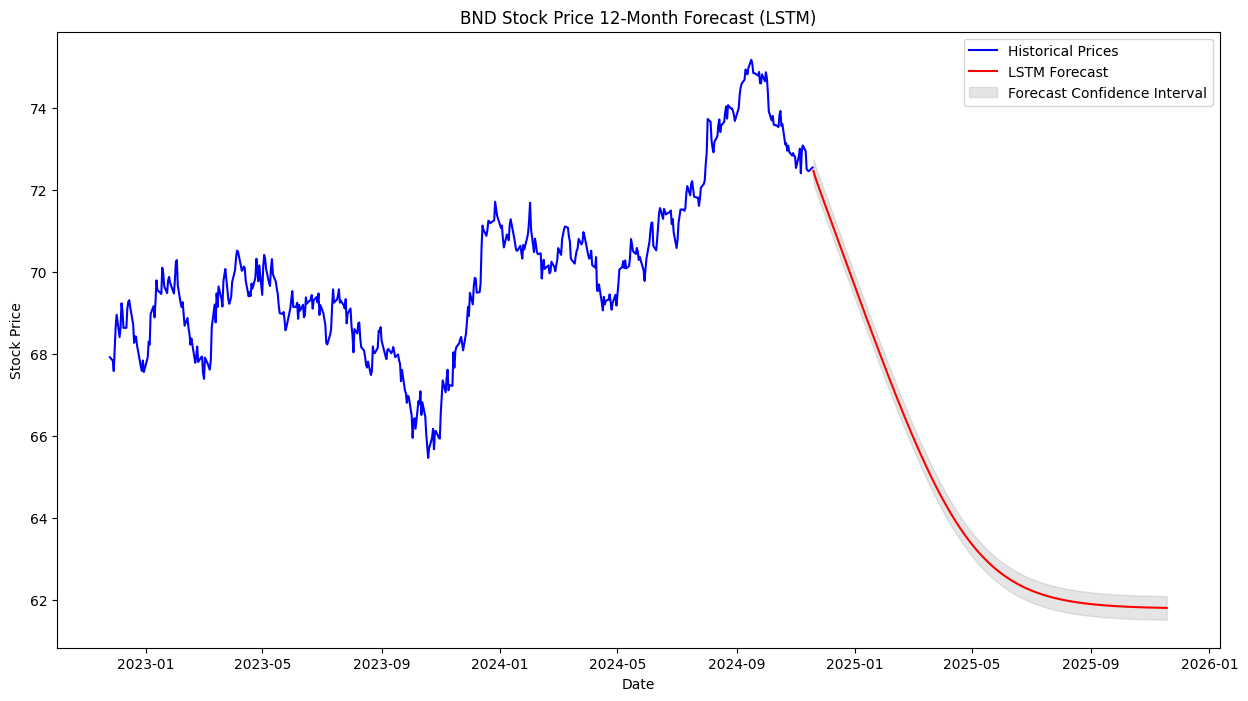

In [40]:
# Plotting forecast
plt.figure(figsize=(15, 8))
plt.plot(bnd_test.index, bnd_test.values, label='Historical Prices', color='blue')
plt.plot(forecast_index, forecast, label='LSTM Forecast', color='red')
plt.fill_between(
    forecast_index,
    lower_bound.flatten(),
    upper_bound.flatten(),
    color='gray', alpha=0.2,
    label='Forecast Confidence Interval'
)
plt.title('BND Stock Price 12-Month Forecast (LSTM)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [41]:
# Trend Analysis
def analyze_trend(forecast):
    start_price = forecast[0][0]
    end_price = forecast[-1][0]
    trend_direction = "upward" if end_price > start_price else "downward" if end_price < start_price else "stable"
    price_change_percentage = ((end_price - start_price) / start_price) * 100
    return trend_direction, price_change_percentage

trend_direction, price_change = analyze_trend(forecast)

# Volatility and Risk Analysis
def analyze_volatility(forecast):
    volatility = np.std(forecast)
    rolling_volatility = pd.Series(forecast.flatten()).rolling(window=30).std()
    high_volatility_periods = rolling_volatility[rolling_volatility > rolling_volatility.mean() + rolling_volatility.std()]
   
    return {
        'overall_volatility': volatility,
        'high_volatility_periods': high_volatility_periods
    }

volatility_analysis = analyze_volatility(forecast)

In [42]:
# Comprehensive Report
print("\n--- BND Stock Price Forecast Analysis (LSTM) ---")
print(f"\nTrend Analysis:")
print(f"Trend Direction: {trend_direction}")
print(f"Price Change: {price_change:.2f}%")
print("\nVolatility and Risk:")
print(f"Overall Volatility: {volatility_analysis['overall_volatility']:.2f}")
print("\nMarket Opportunities:")
for opp in opportunities[:5]:  # Limit to first 5 for brevity
    print(f"Potential Price Increase: {opp['potential_increase']:.2f} from {opp['start_date']} to {opp['end_date']}")
print("\nMarket Risks:")
for risk in risks[:5]:  # Limit to first 5 for brevity
    print(f"Potential Price Decline: {risk['potential_decline']:.2f} from {risk['start_date']} to {risk['end_date']}")


--- BND Stock Price Forecast Analysis (LSTM) ---

Trend Analysis:
Trend Direction: downward
Price Change: -14.72%

Volatility and Risk:
Overall Volatility: 3.21

Market Opportunities:

Market Risks:
Potential Price Decline: 0.09 from 2024-11-19 00:00:00 to 2024-11-20 00:00:00
Potential Price Decline: 0.08 from 2024-11-20 00:00:00 to 2024-11-21 00:00:00
Potential Price Decline: 0.07 from 2024-11-21 00:00:00 to 2024-11-22 00:00:00
Potential Price Decline: 0.07 from 2024-11-22 00:00:00 to 2024-11-23 00:00:00
Potential Price Decline: 0.07 from 2024-11-23 00:00:00 to 2024-11-24 00:00:00


In [47]:
# Create a DataFrame for forecast and confidence intervals
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecast': forecast.flatten(),
    'Lower_Bound': lower_bound.flatten(),
    'Upper_Bound': upper_bound.flatten()
})

# Add trend and volatility analysis
forecast_df['Trend'] = trend_direction
forecast_df['Price_Change_Percentage'] = price_change

# Save opportunities and risks (optional)
opportunities_df = pd.DataFrame(opportunities)
risks_df = pd.DataFrame(risks)

# Save the forecast DataFrame to a CSV file
forecast_df.to_csv('../data/forcasted/bnd_forecast.csv', index=False)
print("Forecast saved to '../data/forcasted/bnd_forecast.csv")

# # Save opportunities and risks as separate CSVs (optional)
# if not opportunities_df.empty:
#     opportunities_df.to_csv('market_opportunities.csv', index=False)
#     print("Market opportunities saved to 'market_opportunities.csv'.")
# if not risks_df.empty:
#     risks_df.to_csv('market_risks.csv', index=False)
#     print("Market risks saved to 'market_risks.csv'.")


Forecast saved to '../data/forcasted/bnd_forecast.csv
